In [4]:
import sys
sys.path.insert(0, "/home/gstupp/projects/metaproteomics")

In [133]:
import os
import requests
import pandas as pd
from tqdm import tqdm
from collections import defaultdict, Counter
from glob import glob
import numpy as np
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

In [6]:
from metaproteomics.file_processing.blazmass_tools import dta_select_parser
from metaproteomics.goatools import obo_parser
goa = obo_parser.GODag()

load obo file /home/gstupp/projects/metaproteomics/metaproteomics/goatools/go-basic.obo
48437 nodes imported


In [7]:
files = glob("data/*/*/*.txt")

In [8]:
files

['data/PA/Triflic/PA triflic 4.txt',
 'data/PA/Triflic/PA triflic 3.txt',
 'data/PA/Triflic/PA triflic 5.txt',
 'data/PA/Sonic/PA sonic 1.txt',
 'data/PA/Sonic/PA sonic 3.txt',
 'data/PA/Sonic/PA sonic 4.txt',
 'data/Jurkat/Triflic/Jurkat triflic 1.txt',
 'data/Jurkat/Triflic/Jurkat triflic test.txt',
 'data/Jurkat/Triflic/Jurkat triflic 2.txt',
 'data/Jurkat/Sonic/Jurkat sonic 7.txt',
 'data/Jurkat/Sonic/Jurkat sonic 1.txt',
 'data/Jurkat/Sonic/Jurkat sonic 8.txt',
 'data/BS/Triflic/BS triflic 3.txt',
 'data/BS/Triflic/BS triflic 1.txt',
 'data/BS/Triflic/BS triflic 2.txt',
 'data/BS/Sonic/BS sonic 3.txt',
 'data/BS/Sonic/BS sonic 4.txt',
 'data/BS/Sonic/BS sonic 2.txt']

In [9]:
df = pd.read_csv("annotations.mapped.gaf", sep="\t", comment="!", header=None)
df = df.rename(columns={1:"id", 4:"go_id", 8:'aspect'})
df = df.query("aspect == 'C'")
df = df.query("go_id != 'GO:0005575'")  # remove 'cellular component'
df.head(2)

,0,id,2,3,go_id,5,6,7,aspect,9,10,11,12,13,14,15,16
2,UniProtKB,A0A024R161,DNAJC25-GNG10,NaN,GO:0043234,GO_REF:0000002,IEA,InterPro:IPR001770|InterPro:IPR015898,C,Guanine nucleotide-binding protein subunit gamma,A0A024R161_HUMAN|hCG_1994888,protein,taxon:9606,20170603,InterPro,NaN,NaN
3,UniProtKB,A0A024R161,DNAJC25-GNG10,NaN,GO:0005622,GO_REF:0000002,IEA,InterPro:IPR001770|InterPro:IPR015898,C,Guanine nucleotide-binding protein subunit gamma,A0A024R161_HUMAN|hCG_1994888,protein,taxon:9606,20170603,InterPro,NaN,NaN


In [10]:
go_annot = df.groupby("id").agg({'go_id': lambda x: set(x)}).to_dict()['go_id']
go_annot['A0A024R161']

{'GO:0005622', 'GO:0005886', 'GO:0043234'}

In [11]:
#{goa[x].name: x for x in set(df[df['aspect'] == 'C']['go_id'])}

In [45]:
def get_proteins(loci):
    loci = [x for x in loci['loci'] if "|" in x['description']]
    for locus in loci:
        locus['uniprot'] = locus['description'].split("|")[1]
    return loci
locus = next(dta_select_parser(files[9], return_reverse=False))
get_proteins(locus)

[{'Descriptive Name': 'Tubulin alpha-1A chain (Fragment) OS=Homo sapiens GN=TUBA1A PE=4 SV=1 ',
  'EMPAI': 5.4268775,
  'Length': 26,
  'Locus': 0,
  'MolWt': 2704,
  'NSAF': 0.0028739145,
  'Sequence Count': 4,
  'Sequence Coverage': 0.8079999999999999,
  'Spectrum Count': 11,
  'Validation Status': 'U',
  'description': 'tr|F8VXZ7|F8VXZ7_HUMAN',
  'pI': 4.9,
  'reverse': False,
  'uniprot': 'F8VXZ7'}]

In [47]:
def get_go_count(file):
    """
    If a locus has multiple proteins, the go annotations for each protein are used and the spectral count assigned
    is divided by the number of proteins in the locus.
    If a protein has multiple go terms, the spectral count for that protein is divided by the number of GO terms
    """
    descr = dict()
    d = defaultdict(int)
    for locus in dta_select_parser(file, return_reverse=False):
        proteins = get_proteins(locus)
        for p in proteins:
            this_go = go_annot.get(p['uniprot'], [])
            descr[p['uniprot']] = {'go': ";".join(this_go), 'q': locus['quantification'], 
                          'go_name': ";".join([goa[x].name for x in this_go]), 
                          'name': p['Descriptive Name']}
            for go in this_go:
                d[go]+=(locus['quantification']/len(proteins))/len(this_go)
    d = dict(d)
    return d, descr

d,p = get_go_count(files[0])
d

{'GO:0005576': 237.83333333333331,
 'GO:0005615': 97.0,
 'GO:0005618': 32.33333333333333,
 'GO:0005622': 1586.6666666666667,
 'GO:0005623': 1392.9666666666667,
 'GO:0005634': 3.3333333333333335,
 'GO:0005694': 37.166666666666664,
 'GO:0005730': 11.5,
 'GO:0005737': 5420.133333333335,
 'GO:0005739': 269.3333333333333,
 'GO:0005777': 3.0,
 'GO:0005829': 1915.1333333333334,
 'GO:0005840': 640.6666666666667,
 'GO:0005886': 1640.1333333333334,
 'GO:0030312': 751.0,
 'GO:0043226': 92.66666666666666,
 'GO:0043234': 1215.1333333333337}

In [48]:
def get_membrane_count(d):
    # cell wall, plasma membrane
    membrane = {'GO:0005618', 'GO:0005886'}
    membrane_count = sum(count for go,count in d.items() if go in membrane)
    not_membrane_count = sum(count for go,count in d.items() if go not in membrane)
    return membrane_count, not_membrane_count

In [66]:
counts = dict()
all_counts = dict()
for file in tqdm(files):
    d,p = get_go_count(file)
    all_counts[file] = {goa[k].name:v for k,v in d.items()}
    membrane_count, not_membrane_count = get_membrane_count(d)
    counts[file] = (membrane_count, not_membrane_count, np.log(not_membrane_count)-np.log(membrane_count))
    pd.DataFrame(p).T.to_csv(file + "_go_counts.csv")

100%|██████████| 18/18 [00:03<00:00,  5.03it/s]


In [67]:
df_out = pd.DataFrame({'files': list(counts.keys()),
 'membrane': [x[0] for x in counts.values()],
 'non-membrane': [x[1] for x in counts.values()],
 'ratio': [x[2] for x in counts.values()],
 'method': ["sonic" if "sonic" in file else "tri" for file in counts],
 'cell': [file.split("/")[1] for file in counts]})
df_out = df_out.sort_values(["cell", "method"])
df_out

,cell,files,membrane,method,non-membrane,ratio
2,BS,data/BS/Sonic/BS sonic 4.txt,1262.133333,sonic,14513.866667,2.442301
7,BS,data/BS/Sonic/BS sonic 2.txt,1474.416667,sonic,15578.583333,2.357635
17,BS,data/BS/Sonic/BS sonic 3.txt,1222.316667,sonic,13971.683333,2.436285
0,BS,data/BS/Triflic/BS triflic 1.txt,1112.233333,tri,12265.766667,2.400442
5,BS,data/BS/Triflic/BS triflic 2.txt,1733.883333,tri,21035.116667,2.495830
9,BS,data/BS/Triflic/BS triflic 3.txt,2092.116667,tri,24973.883333,2.479654
13,Jurkat,data/Jurkat/Sonic/Jurkat sonic 1.txt,1033.152608,sonic,19283.167630,2.926618
14,Jurkat,data/Jurkat/Sonic/Jurkat sonic 7.txt,1270.553510,sonic,22353.405834,2.867526
16,Jurkat,data/Jurkat/Sonic/Jurkat sonic 8.txt,795.449164,sonic,20567.650292,3.252568
3,Jurkat,data/Jurkat/Triflic/Jurkat triflic test.txt,303.136117,tri,7763.900345,3.243058


In [68]:
df_out.to_csv("df_out.csv")

In [69]:
all_counts = pd.DataFrame(all_counts)
all_counts

,data/BS/Sonic/BS sonic 2.txt,data/BS/Sonic/BS sonic 3.txt,data/BS/Sonic/BS sonic 4.txt,data/BS/Triflic/BS triflic 1.txt,data/BS/Triflic/BS triflic 2.txt,data/BS/Triflic/BS triflic 3.txt,data/Jurkat/Sonic/Jurkat sonic 1.txt,data/Jurkat/Sonic/Jurkat sonic 7.txt,data/Jurkat/Sonic/Jurkat sonic 8.txt,data/Jurkat/Triflic/Jurkat triflic 1.txt,data/Jurkat/Triflic/Jurkat triflic 2.txt,data/Jurkat/Triflic/Jurkat triflic test.txt,data/PA/Sonic/PA sonic 1.txt,data/PA/Sonic/PA sonic 3.txt,data/PA/Sonic/PA sonic 4.txt,data/PA/Triflic/PA triflic 3.txt,data/PA/Triflic/PA triflic 4.txt,data/PA/Triflic/PA triflic 5.txt
Golgi apparatus,NaN,NaN,NaN,NaN,NaN,NaN,80.439569,71.966568,67.636642,20.472386,22.331316,25.663306,NaN,NaN,NaN,NaN,NaN,NaN
cell,1587.416667,2006.400000,1435.800000,351.400000,500.466667,856.533333,830.339838,1148.537051,743.189309,176.019966,176.958958,317.244220,3414.250000,3211.333333,1417.283333,1248.066667,1392.966667,1111.733333
cell wall,51.250000,38.250000,49.166667,102.000000,110.416667,221.916667,NaN,NaN,NaN,NaN,NaN,NaN,25.166667,31.333333,11.500000,34.000000,32.333333,22.166667
chromosome,11.000000,14.166667,14.000000,21.333333,26.833333,32.500000,638.975840,187.775317,976.876355,124.148775,169.061937,261.142880,43.250000,113.500000,9.750000,11.500000,37.166667,16.666667
cilium,NaN,NaN,NaN,NaN,NaN,NaN,88.161832,111.971212,79.283046,16.281859,18.352710,24.294503,NaN,NaN,NaN,NaN,NaN,NaN
cytoplasm,8331.250000,7107.400000,8183.383333,7101.233333,12918.300000,14159.700000,2220.310294,3043.350632,2224.720620,591.011250,520.179551,928.054088,7768.500000,6689.500000,4556.533333,5150.900000,5420.133333,5492.400000
cytoplasmic chromosome,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cytoplasmic vesicle,NaN,NaN,NaN,NaN,NaN,NaN,449.672720,500.767437,456.696488,85.225118,99.426890,143.239438,NaN,NaN,NaN,NaN,NaN,NaN
cytoskeleton,3.000000,2.666667,3.666667,6.000000,2.333333,2.333333,943.837659,1575.910760,889.928227,303.392544,231.079433,460.870453,NaN,NaN,NaN,NaN,NaN,NaN
cytosol,2046.750000,1742.150000,1676.800000,1334.733333,1956.550000,2673.533333,1599.683125,1680.236219,1438.976452,382.252868,428.092076,563.148853,2767.416667,2601.000000,1893.950000,2424.566667,1915.133333,2398.900000


In [123]:
show = ['cell wall'] + list(all_counts.sum(axis=1).sort_values()[-9:].index)
all_counts2 = all_counts[all_counts.index.isin(show)].T
other = all_counts[~all_counts.index.isin(show)].sum()
all_counts2['other'] = other

In [124]:
show

['cell wall',
 'nucleus',
 'extracellular space',
 'organelle',
 'protein complex',
 'plasma membrane',
 'cell',
 'intracellular',
 'cytosol',
 'cytoplasm']

In [126]:
all_counts2[show]

,cell wall,nucleus,extracellular space,organelle,protein complex,plasma membrane,cell,intracellular,cytosol,cytoplasm
data/BS/Sonic/BS sonic 2.txt,51.250000,NaN,NaN,75.750000,777.833333,1423.166667,1587.416667,2139.750000,2046.750000,8331.250000
data/BS/Sonic/BS sonic 3.txt,38.250000,NaN,NaN,58.500000,670.233333,1184.066667,2006.400000,1819.750000,1742.150000,7107.400000
data/BS/Sonic/BS sonic 4.txt,49.166667,NaN,NaN,63.583333,714.966667,1212.966667,1435.800000,1897.916667,1676.800000,8183.383333
data/BS/Triflic/BS triflic 1.txt,102.000000,NaN,NaN,66.500000,366.900000,1010.233333,351.400000,2248.666667,1334.733333,7101.233333
data/BS/Triflic/BS triflic 2.txt,110.416667,NaN,NaN,82.166667,653.633333,1623.466667,500.466667,4041.083333,1956.550000,12918.300000
data/BS/Triflic/BS triflic 3.txt,221.916667,1.000000,NaN,123.750000,783.533333,1870.200000,856.533333,4805.416667,2673.533333,14159.700000
data/Jurkat/Sonic/Jurkat sonic 1.txt,NaN,2278.250253,2172.257954,2193.969547,1036.113975,1033.152608,830.339838,671.267106,1599.683125,2220.310294
data/Jurkat/Sonic/Jurkat sonic 7.txt,NaN,2012.668065,3383.844602,3402.669139,1041.758812,1270.553510,1148.537051,748.960267,1680.236219,3043.350632
data/Jurkat/Sonic/Jurkat sonic 8.txt,NaN,2477.212213,2596.867904,2637.001660,970.290394,795.449164,743.189309,647.669473,1438.976452,2224.720620
data/Jurkat/Triflic/Jurkat triflic 1.txt,NaN,564.390919,474.883818,499.101938,249.038302,181.450836,176.019966,150.665104,382.252868,591.011250


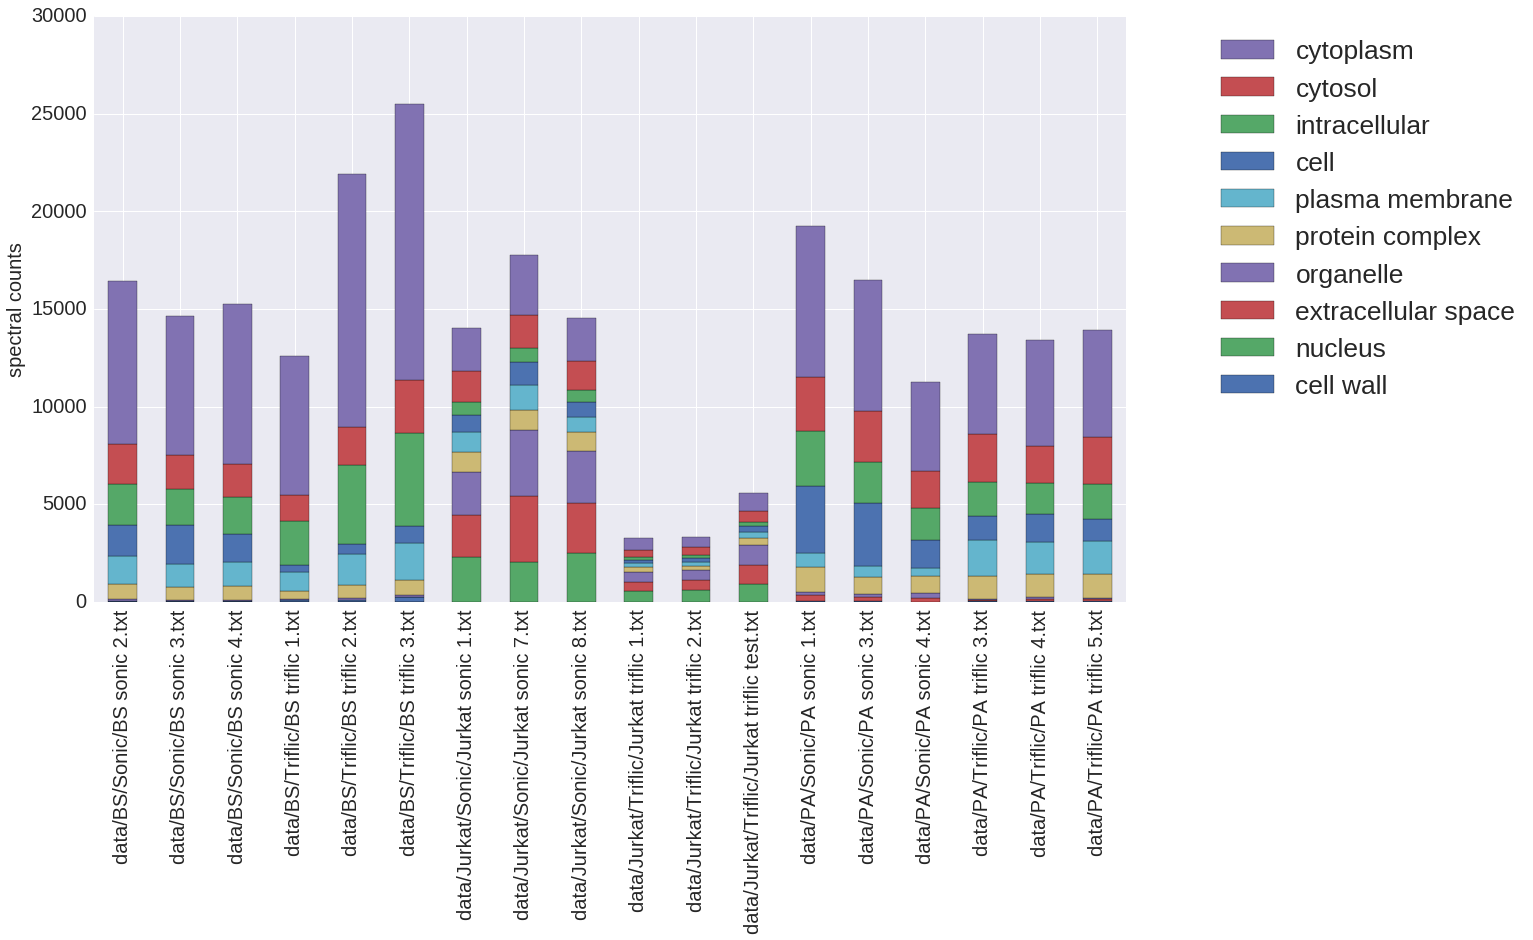

In [136]:
ax = all_counts2[show].plot.bar(stacked=True, legend=False)
ax.set_ylabel("spectral counts")
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches[::-1], labels[::-1], bbox_to_anchor=(1.4, 1), fontsize='large')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)